170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train:  (50000, 32, 32, 3) (50000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


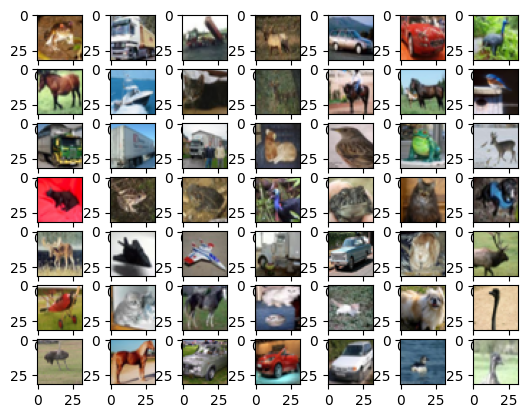

In [1]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

(trainX, trainY), (testX, testY) = load_data()
print('Train: ', trainX.shape, trainY.shape)
print('Test: ', testX.shape, testY.shape)
for i in range(49):
    pyplot.subplot(7, 7, i+1)
    pyplot.imshow(trainX[i])
pyplot.show()

In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten , Dropout , LeakyReLU
from tensorflow.keras.utils import plot_model
import numpy as np

In [3]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

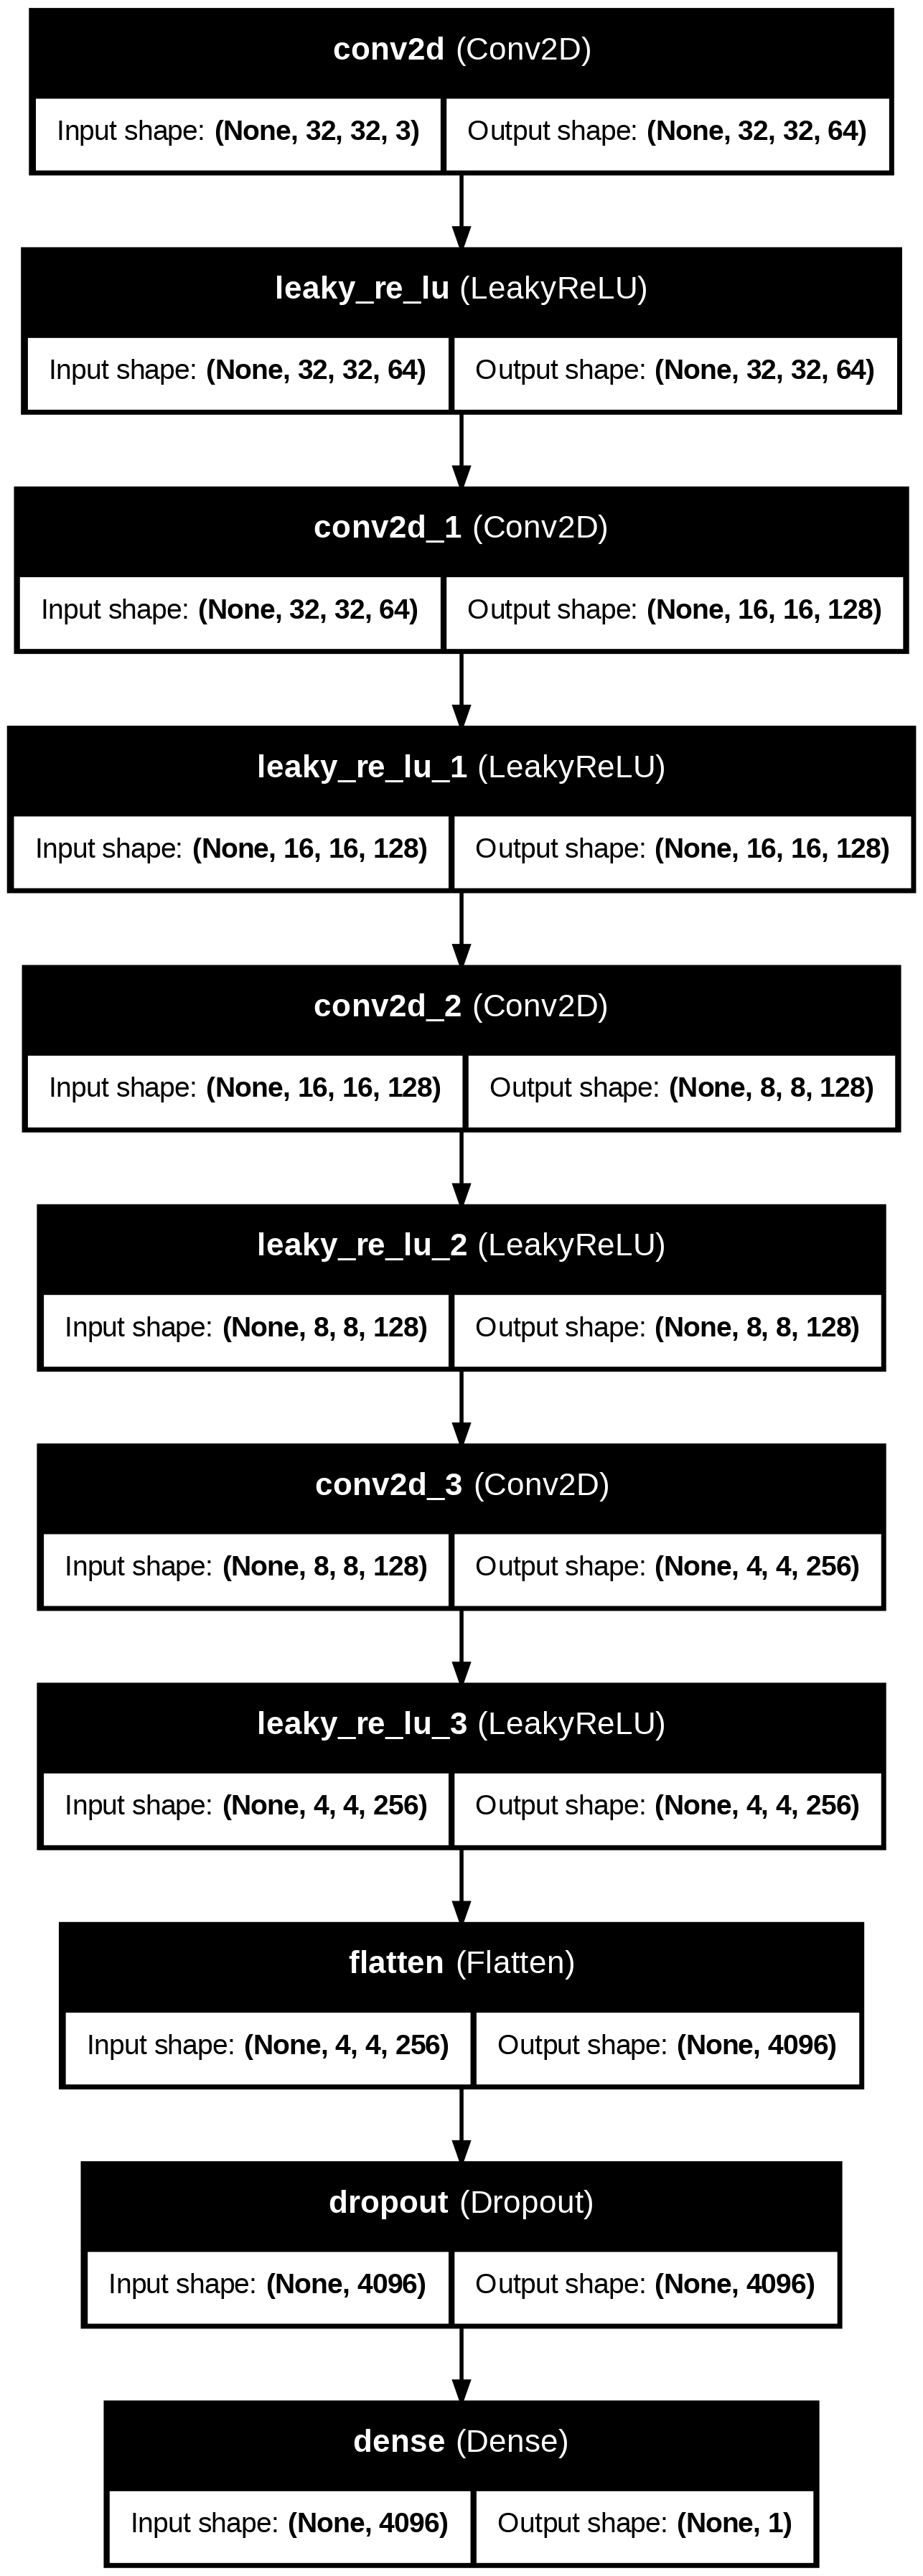

In [4]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [6]:
X = load_real_samples()
X[0].shape

(32, 32, 3)

In [7]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y
    # gives you n_samples where X is the rows and y i sthe label if its real or fake

In [8]:
X , y = generate_real_samples(X,64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [9]:
def generate_fake_samples(n_samples):
  X = np.random.rand(32 * 32 * 3 * n_samples) # generate uniform random numbers in [0,1]
  # update to have the range [-1,1]
  X = -1 + X * 2
  X = X.reshape((n_samples, 32, 32, 3))
  y = np.zeros((n_samples, 1))
  return X, y
# the above function is generated by generator in GAN above is just our noise

In [10]:
X,y = generate_fake_samples(64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [11]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)

  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate 'fake' samples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

> Again from reserach it was seen that we train on real samples and update the weights first and then on fake samples and update the weights instead of training in mixed manner of real and fake because it was seen that in this was performance was comparitively good

In [12]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


>1 real=30% fake=16%
>2 real=42% fake=34%
>3 real=47% fake=46%
>4 real=52% fake=56%
>5 real=59% fake=63%
>6 real=65% fake=68%
>7 real=69% fake=72%
>8 real=73% fake=74%
>9 real=75% fake=76%
>10 real=77% fake=78%
>11 real=79% fake=80%
>12 real=80% fake=81%
>13 real=82% fake=82%
>14 real=83% fake=84%
>15 real=84% fake=85%
>16 real=85% fake=85%
>17 real=86% fake=86%
>18 real=87% fake=87%
>19 real=87% fake=88%
>20 real=88% fake=88%
>21 real=89% fake=89%
>22 real=89% fake=89%
>23 real=90% fake=90%
>24 real=90% fake=90%
>25 real=90% fake=91%
>26 real=91% fake=91%
>27 real=91% fake=91%
>28 real=91% fake=92%
>29 real=92% fake=92%
>30 real=92% fake=92%
>31 real=92% fake=92%
>32 real=93% fake=93%
>33 real=93% fake=93%
>34 real=93% fake=93%
>35 real=93% fake=93%
>36 real=93% fake=94%
>37 real=94% fake=94%
>38 real=94% fake=94%
>39 real=94% fake=94%
>40 real=94% fake=94%
>41 real=94% fake=94%
>42 real=94% fake=94%
>43 real=94% fake=95%
>44 real=95% fake=95%
>45 real=95% fake=95%
>46 real=95% fake=9

In [13]:
from keras.layers import Dense , Reshape, Conv2D , Conv2DTranspose

In [14]:
# define generator

def define_generator(latent_dim):
  model = Sequential()
  # foundatino for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes , input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128,(4,4) , strides=(2,2) , padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128,(4,4) , strides=(2,2) , padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128,(4,4) , strides=(2,2) , padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3) , activation='tanh' , padding='same'))
  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

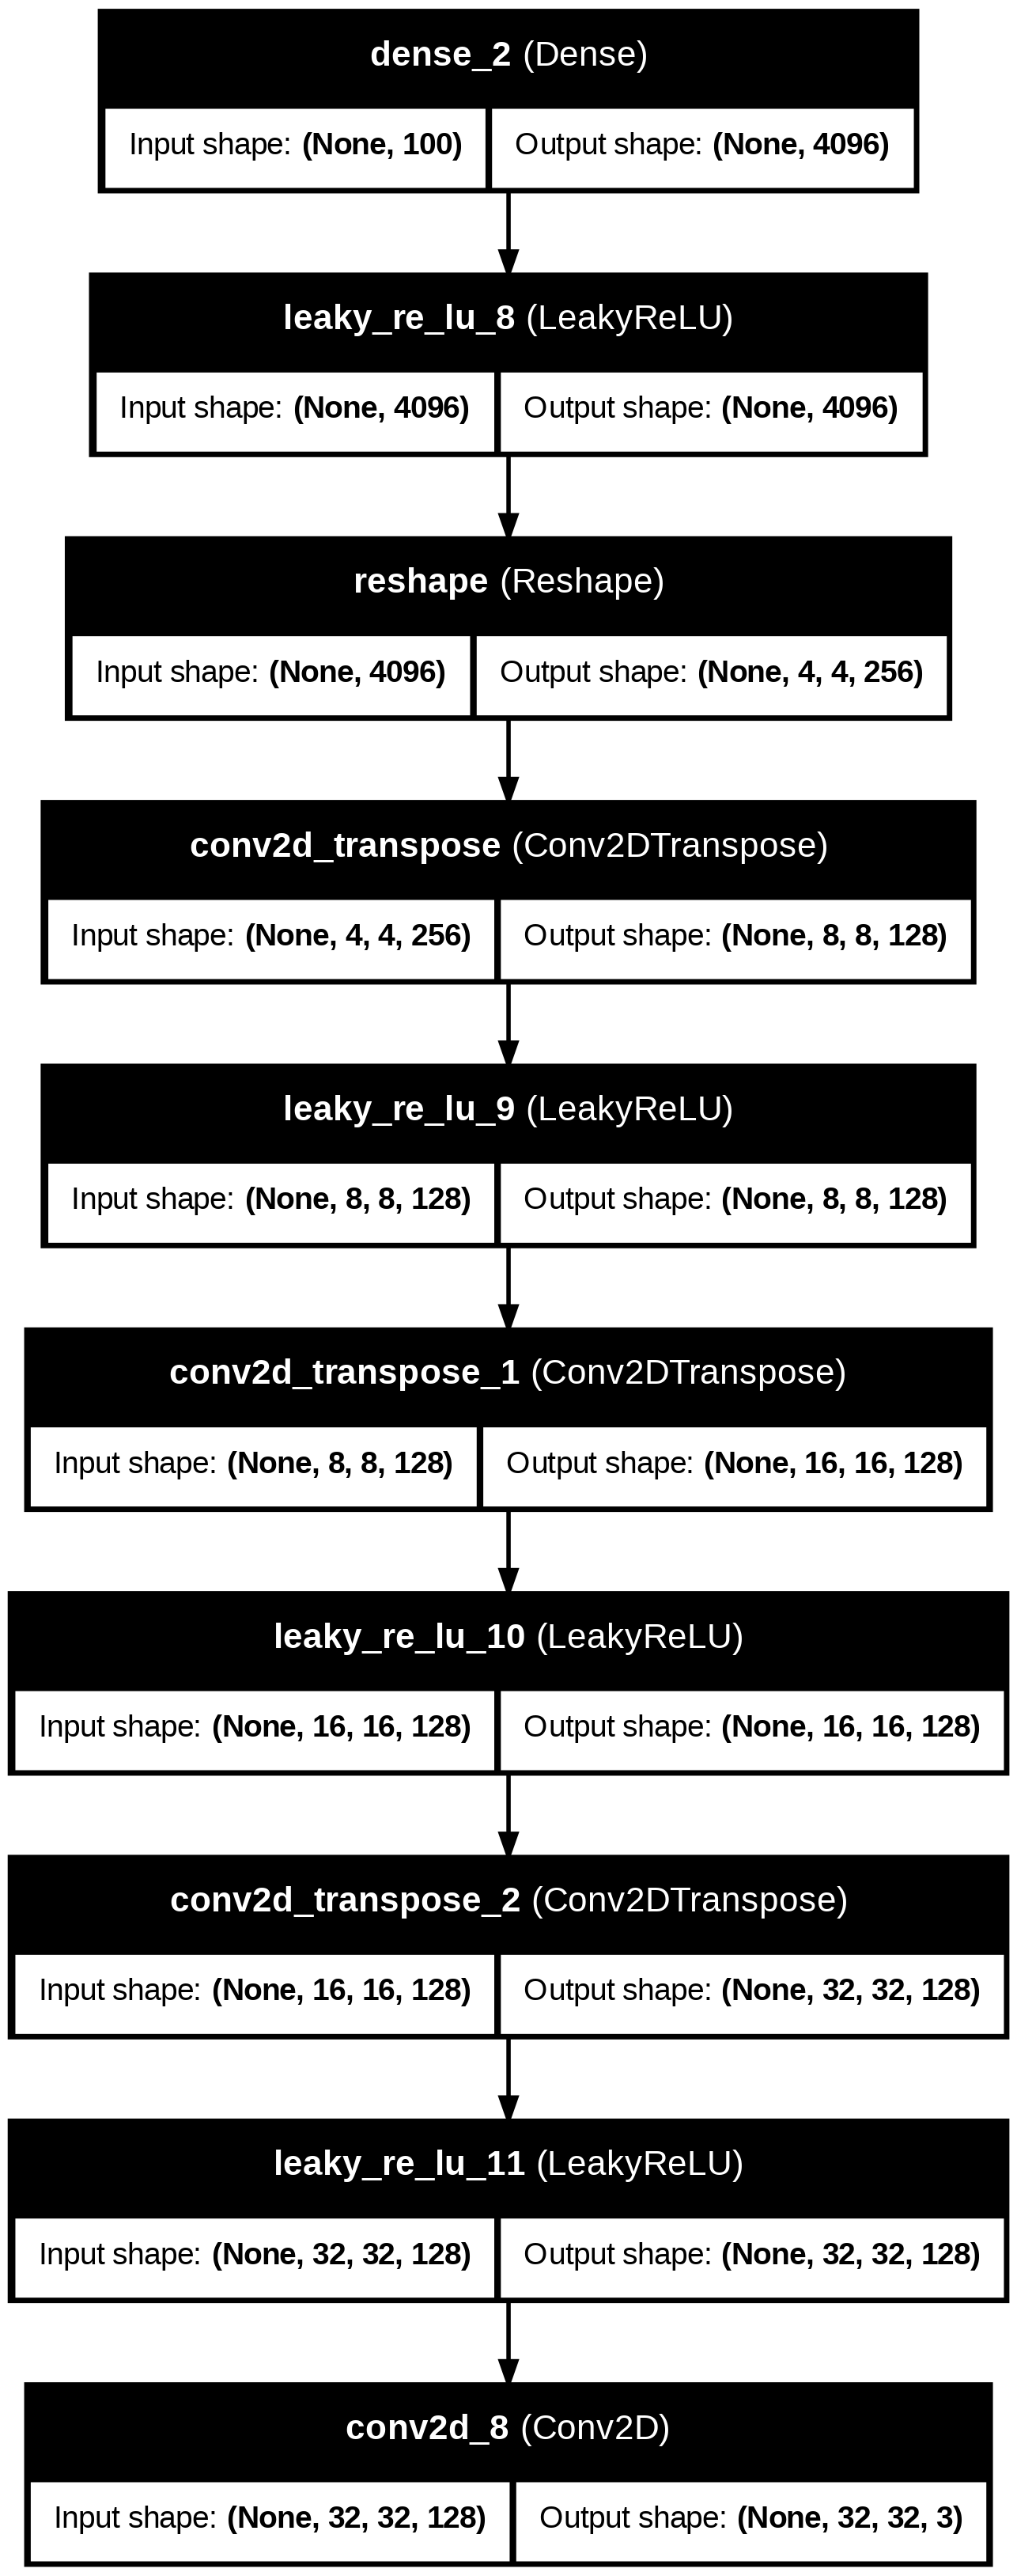

In [15]:
latent_dim = 100 # you can take anything as its noise at beginnning
# define generator model
model = define_generator(latent_dim)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim , n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [17]:
# use the generator to generate n fake examples , with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


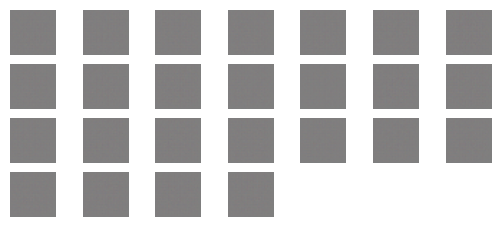

In [18]:
# size of the latent space
latent_dim = 100
# create the generator
model = define_generator(latent_dim)
# generate n fake examples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] tp [0,1]
X = (X+1)/2.0
# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(7, 7, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(X[i])
pyplot.show()

In [19]:
# define the combined generator and discriminator model , for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 32, 32, 3)      │     1,466,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 1)              │       522,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

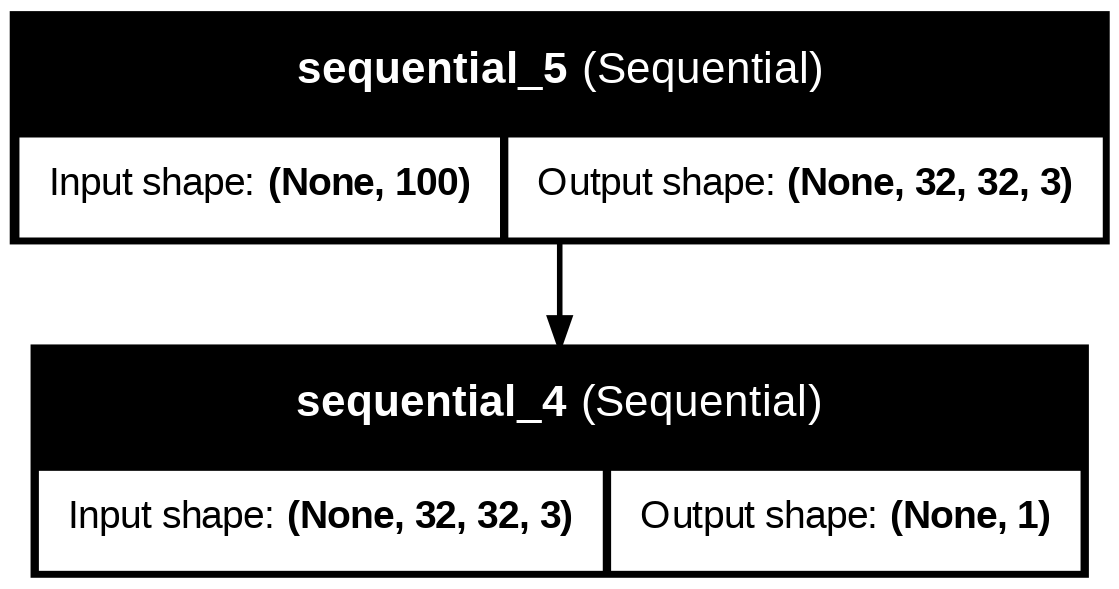

In [20]:
# size of the latent space
latent_dim = 100
# create the disciminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

### Training our model

In [22]:
def save_plot(exapmles , epoch , n = 7):
  # scale from  [-1,1] to [0,1]
  examples = (examples + 1)/2.0
  # plot images
  for i in range(n*n):
    # define subplot
    pyplot.subplot(n,n,1+i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i])
    # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

In [23]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples (dataset, n_samples)
  # evaluate discriminator on real examples
  _ , acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples (g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _ , acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  #save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [24]:
# train the generator and discriminator
def train(g_model , d_model , gan_model , dataset , latent_dim , n_epoch = 200 ,n_batch =128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epoch):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset , half_batch )
      # update discriminator model weights
      d_loss1 , _ = d_model.train_on_batch(X_real , y_real)
      # generate 'fake' examples
      X_fake , y_fake = generate_fake_samples(g_model , latent_dim , half_batch)
      # update discriminator model weights
      d_loss2 , _ = d_model.train_on_batch(X_fake , y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim , n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan , y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance sometimes
    if (i+1)%10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
train(g_model , d_model, gan_model , dataset , latent_dim ,n_epoch=200 , n_batch=128)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 
>1, 1/390, d1=0.717, d2=0.705 g=0.694
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>1, 2/390, d1=0.712, d2=0.707 g=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>1, 3/390, d1=0.710, d2=0.708 g=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>1, 4/390, d1=0.709, d2=0.707 g=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>1, 5/390, d1=0.709, d2=0.708 g=0.691
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>1, 6/390, d1=0.708, d2=0.708 g=0.690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1, 7/390, d1=0.709, d2=0.708 g=0.689
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1, 8/390, d1=0.709, d2=0.709 g=0.687
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>1, 9/390, d1=0.710, d2=0.711 g=0.684
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>1, 10/390, d1=0.711, d2=0.713 g=0.681
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>1, 11/390, d1=0.713, d2=0.715 g=0.677
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>1, 12/390, d1=0.715, d2=0.717 g=0.672
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>1, 13/390, d1=0.717, d2=0.720 g=0.667
2/2 ━━━